In [2]:
from vnstock import *
from function import *
from operators import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests


##### VN30

In [3]:
url = "https://www.hsx.vn/Modules/Listed/Web/StockIndex/1964531007?_search=false&nd=1676183900812&rows=2147483647&page=1&sidx=id&sord=desc"

payload={}
headers = {
  'Accept': 'application/json, text/javascript, */*; q=0.01',
  'Accept-Language': 'en-US,en;q=0.9',
  'Connection': 'keep-alive',
  'Cookie': 'ASP.NET_SessionId=pv5aylwinwlvuoxvulhw1520; TS016df111=01343ddb6ae104c44f5bd539bb677455f6c3c2c4df6c30affaabd5f271ae74106c49431df7eb64f81a41f37e5dd94c1047affa38c49a55d7f4246abf80c6c61b573c04870b; TS0d710d04027=085cef26a9ab20001b536bb274476a68a87b2efed3eb5f90c7f8ebe4891202027eb307b54dfe9d0408ba0fd881113000269cecb2cea2fc0bf24e765a0cd09051571287443d1e20737591cfee5ff928ad1f587f92d2a619403728c979f26370b4',
  'Referer': 'https://www.hsx.vn/Modules/Listed/Web/StockIndexView/1964531007',
  'Sec-Fetch-Dest': 'empty',
  'Sec-Fetch-Mode': 'cors',
  'Sec-Fetch-Site': 'same-origin',
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36 Edg/110.0.1587.41',
  'X-KL-Ajax-Request': 'Ajax_Request',
  'X-Requested-With': 'XMLHttpRequest',
  'sec-ch-ua': '"Chromium";v="110", "Not A(Brand";v="24", "Microsoft Edge";v="110"',
  'sec-ch-ua-mobile': '?0',
  'sec-ch-ua-platform': '"Windows"'
}

response = requests.request("GET", url, headers=headers, data=payload)
a = response.json()
ticket=[]
# VN 30
for i in range(30):
    ticket.append(a["rows"][i]["cell"][2][:3])
    
frame = []
for i in ticket:
    a = stock_historical_data(symbol=i, 
                            start_date="2013-01-01", 
                            end_date='2023-02-11')    
    a["ticker"] = i
    frame.append(a)
    
q = pd.concat(frame)
close= q.pivot_table(values="Close", columns="ticker", index="TradingDate")
high= q.pivot_table(values="High", columns="ticker", index="TradingDate")
low= q.pivot_table(values="Low", columns="ticker", index="TradingDate")
open= q.pivot_table(values="Open", columns="ticker", index="TradingDate")


### Markowitz model

In [5]:
w = marko_weights(close)
returns=close.pct_change()

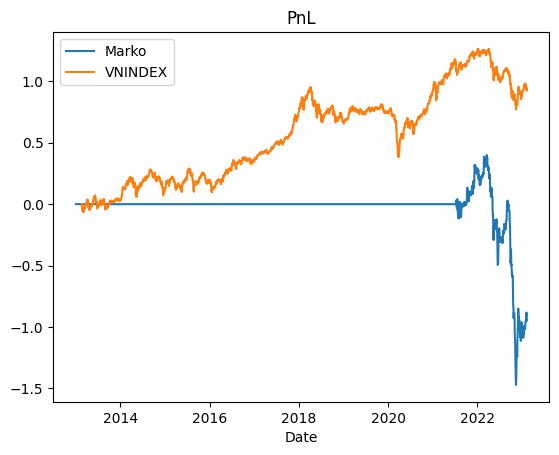

In [6]:
a = Simresult(w,returns=returns)
a.plot_pnl("Marko")

m=get_index_series(index_code='VNINDEX', time_range='TenYears')
m["i"]=pd.to_datetime(m["tradingDate"])
plt.plot(m["i"],np.cumsum(m["indexValue"].pct_change()), label="VNINDEX")
plt.legend()

In [3]:
close_t5=close-close.shift(5)

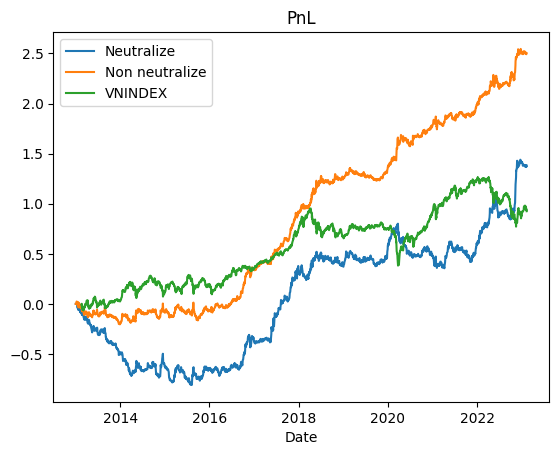

In [4]:
returns = close.pct_change()
w  = weights(close_t5, neutrali=1)
neu=Simresult(weights=w,returns=returns)
neu.plot_pnl(type="Neutralize")

w1  = weights(close_t5, neutrali=0)
non_neu=Simresult(weights=w1,returns=returns)
non_neu.plot_pnl(type="Non neutralize")

m=get_index_series(index_code='VNINDEX', time_range='TenYears')
m["i"]=pd.to_datetime(m["tradingDate"])
plt.plot(m["i"],np.cumsum(m["indexValue"].pct_change()), label="VNINDEX")
plt.legend()

In [59]:
neu.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.116131,1.026037,0.581226,0.458632,199.803249


In [60]:
neu.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.289115,-2.886706,0.628499,-1.957878,-460.008984
2014,-0.027787,-0.257894,0.603191,-0.055352,-46.065815
2015,0.025631,0.238350,0.585701,0.049861,43.760729
2016,0.372940,3.047322,0.581179,2.441085,641.695733
2017,0.467491,3.511050,0.542485,3.259341,861.758345
2018,0.032162,0.279907,0.577621,0.066049,55.680814
2019,0.094289,1.042111,0.622486,0.405582,151.471136
2020,-0.009300,-0.083557,0.577321,-0.010605,-16.109737
2021,0.139454,1.403362,0.563189,0.698326,247.614661


In [61]:
non_neu.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.250125,1.453026,0.594381,0.942582,420.81521


In [62]:
non_neu.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.201883,-1.312268,0.633236,-0.740952,-318.811946
2014,0.116070,0.680709,0.611300,0.296616,189.873894
2015,0.022471,0.146641,0.596954,0.028451,37.643256
2016,0.403735,2.814558,0.548013,2.415812,736.725821
2017,0.581298,4.198096,0.518273,4.446033,1121.606869
2018,0.329990,1.630178,0.582216,1.227280,566.783493
2019,0.124867,1.159499,0.625107,0.518224,199.753455
2020,0.420794,2.003896,0.587899,1.695347,715.758765
2021,0.210838,1.288363,0.609508,0.757745,345.914824


### alpha = rank(ts_delta(close,5))

In [34]:
alpha = rank(ts_delta(close,5))
w =weights(alpha)
w1 =weights(alpha,neutrali=1)

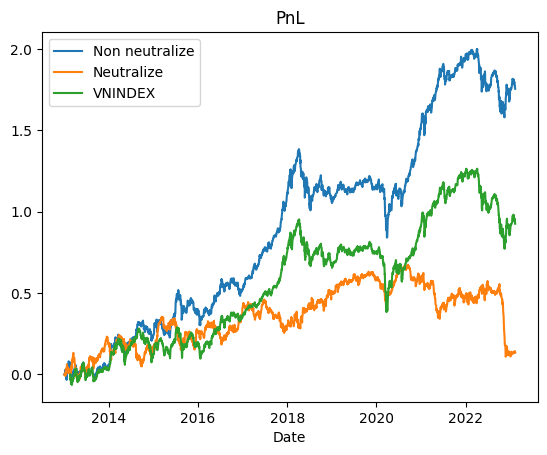

In [35]:
returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(-1*w1,returns)
b.plot_pnl("Neutralize")

m=get_index_series(index_code='VNINDEX', time_range='TenYears')
m["i"]=pd.to_datetime(m["tradingDate"])
plt.plot(m["i"],np.cumsum(m["indexValue"].pct_change()), label="VNINDEX")
plt.legend()

In [36]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.175442,0.890848,0.279455,0.705854,627.801844


In [37]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.013438,0.079706,1.155663,0.008595,11.627919


### alpha = rank(ts_stddev(close,20)/(ts_sum(close,20)/20))

In [15]:
alpha2 = rank(ts_std(close,20)/(ts_sum(close,20)/20))

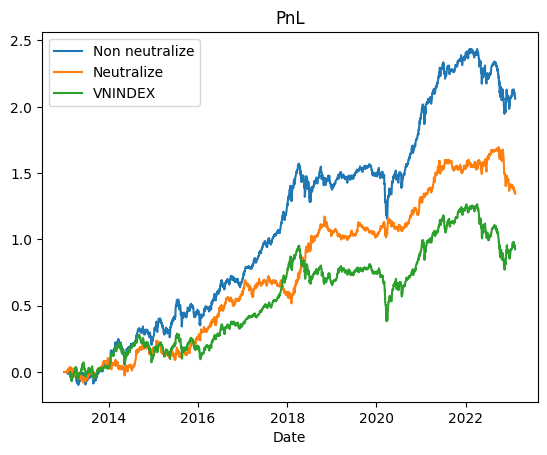

In [38]:
w =weights(alpha2, neutrali=0)
w1 =weights(alpha2,neutrali=1)

a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

m=get_index_series(index_code='VNINDEX', time_range='TenYears')
m["i"]=pd.to_datetime(m["tradingDate"])
plt.plot(m["i"],np.cumsum(m["indexValue"].pct_change()), label="VNINDEX")
plt.legend()

In [39]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.205999,0.929871,0.077905,1.512068,2644.216304


In [40]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.134427,0.752887,0.321123,0.487122,418.615541


### alpha = (close-ts_min(low,14))/(ts_max(high,14)-ts_min(low,14))*100

In [19]:
alpha3 = (close-ts_min(low,14))/(ts_max(high,14)-ts_min(low,14))*100

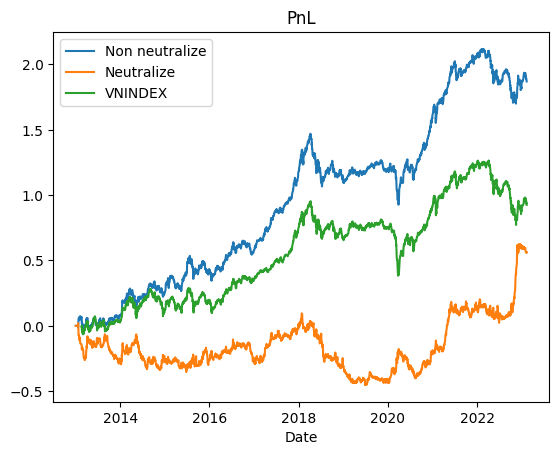

In [20]:
w =weights(alpha3, neutrali=0)
w1 =weights(alpha3,neutrali=1)

a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

m=get_index_series(index_code='VNINDEX', time_range='TenYears')
m["i"]=pd.to_datetime(m["tradingDate"])
plt.plot(m["i"],np.cumsum(m["indexValue"].pct_change()), label="VNINDEX")
plt.legend()

In [21]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.186949,0.97842,0.238743,0.865809,783.056815


In [22]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.056085,0.297724,1.034103,0.069336,54.235464


### close-ts_product(close,2)^0.5

In [51]:
alpha4 = close-ts_product(close,2)**0.5

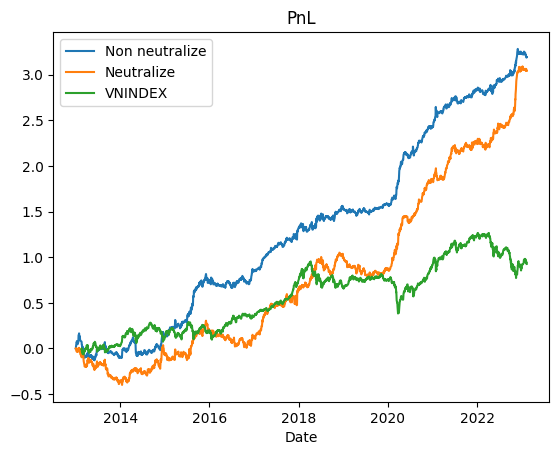

In [52]:
w = weights(alpha4,neutrali=0)
w1 =weights(alpha4,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

m=get_index_series(index_code='VNINDEX', time_range='TenYears')
m["i"]=pd.to_datetime(m["tradingDate"])
plt.plot(m["i"],np.cumsum(m["indexValue"].pct_change()), label="VNINDEX")
plt.legend()

In [53]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.319236,1.777437,1.331062,0.870465,239.835776


In [54]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.304162,1.421887,2.427679,0.503295,125.289411


### alpha6
a = ts_sum(open>close,20)/ts_sum(open<close,20);

b = ts_sum(open>close,250)/ts_sum(open<close,250);

rank(a/b)

In [47]:
a=ts_sum(1*(open>close),20)/ts_sum(1*(open<close),20)
b=ts_sum(1*(open>close),250)/ts_sum(1*(open<close),250)
alpha6=rank(a/b)

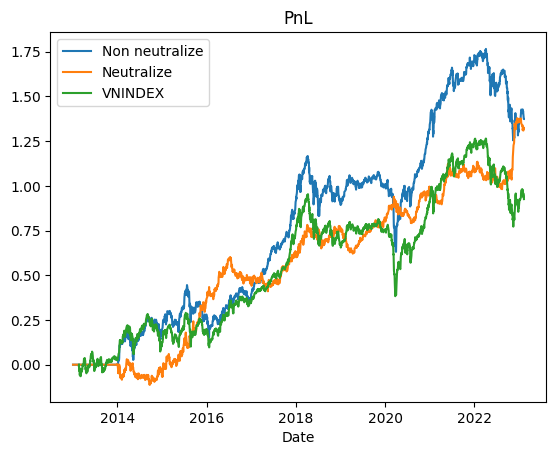

In [48]:
w =weights(alpha6, neutrali=0)
w1 =-1*weights(alpha6,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

m=get_index_series(index_code='VNINDEX', time_range='TenYears')
m["i"]=pd.to_datetime(m["tradingDate"])
plt.plot(m["i"],np.cumsum(m["indexValue"].pct_change()), label="VNINDEX")
plt.legend()

In [49]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.132059,0.910868,0.501322,0.467499,263.420573


In [50]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.137306,0.704386,0.121601,0.748492,1129.154626
